In [1]:
import pandas as pd
import featurewiz as fw

from gower.gower_dist import *

Imported 0.2.6 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



Simple example from D'Orazio

In [2]:
ex = pd.DataFrame({"Sex1": ["M", "M", "F", "F", "F", "M", "M", "F", "F", "F"],
                   "Sex2": ["M", "M", "F", "F", "F", "F", "F", "M", "M", "M"],
                   "Age1": [15] * 10,
                   "Age2": [15, 36, 58, 78, 100, 15, 36, 58, 78, 100]})
distances = np.diag(gower_matrix(ex[["Sex1", "Age1"]].to_numpy(), ex[["Sex2", "Age2"]].to_numpy(), weight_cat="uniform"))
print(distances)
ex.loc[np.argsort(distances)]

  0%|          | 0/1 [00:00<?, ?it/s]

[1.] [2.99889424]


  0%|          | 0/10 [00:00<?, ?it/s]

[0.         0.18527704 0.37937679 0.55583112 0.74993087 0.25006913
 0.43534617 0.62944592 0.80590025 1.        ]


,Sex1,Sex2,Age1,Age2
0,M,M,15,15
1,M,M,15,36
5,M,F,15,15
2,F,F,15,58
6,M,F,15,36
3,F,F,15,78
7,F,M,15,58
4,F,F,15,100
8,F,M,15,78
9,F,M,15,100


Laptops dataset

In [3]:
laptops = pd.read_csv("laptops/laptops_train.csv", index_col=0)
print(laptops.shape)
print(laptops.apply(lambda col: col.unique(), axis=0).apply(len))
laptops.drop(["Operating System Version", "Model Name"], axis=1, inplace=True)
laptops.RAM = np.log2(laptops.RAM.str[:-2].astype(float))  # all in GB
laptops.Weight = laptops.Weight.str[:-2].astype(float)  # all in kg
laptops["Screen Size"] = laptops["Screen Size"].str[:-1].astype(float)  # all in inches

(977, 12)
Model Name                  488
Category                      6
Screen Size                  18
Screen                       38
CPU                         106
RAM                           8
 Storage                     36
GPU                          98
Operating System              7
Operating System Version      5
Weight                      166
Price                       639
dtype: int64


[1. 1. 1. 1. 1. 1.] [1. 1. 1. 1.]


  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

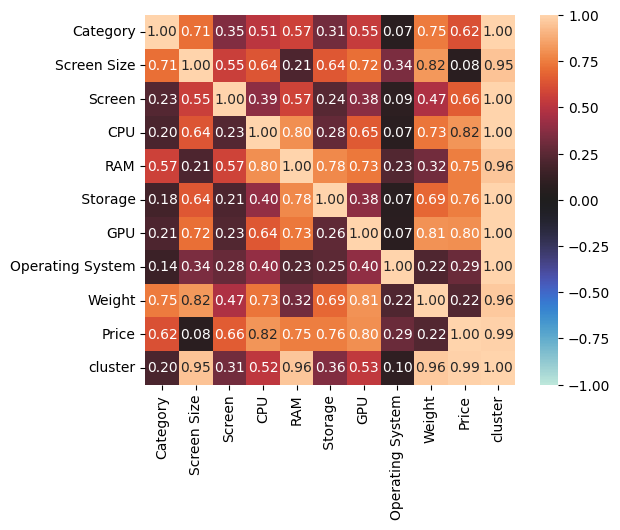

{'eps': 0.1, 'min_samples': 1} 0.2878638560346818 0.8064521276875701
{1: 545, 2: 71, 3: 29, 4: 16, 5: 12, 6: 4, 7: 4, 10: 1, 17: 1}


,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Weight,Price,cluster
Manufacturer,,,,,,,,,,,
HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,3.000000,256GB SSD,Intel HD Graphics 620,Windows,1.86,6135480.00,64
HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,3.000000,256GB SSD,Intel HD Graphics 620,Windows,1.96,5326219.08,64
Dell,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,3.000000,256GB SSD,Intel HD Graphics 620,Windows,1.60,7638228.00,64
Lenovo,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,2.584963,256GB SSD,Intel HD Graphics 620,Windows,2.20,5148468.00,64
HP,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,3.000000,256GB SSD,Intel HD Graphics 620,Windows,1.95,8714160.00,64
...,...,...,...,...,...,...,...,...,...,...,...
Asus,Notebook,15.6,Full HD 1920x1080,Intel Core i3 7100U 2.4GHz,2.584963,256GB SSD,Nvidia GeForce 920M,Windows,2.00,5130684.00,94
HP,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,3.000000,256GB SSD,AMD Radeon 530,Windows,1.91,6393348.00,96
HP,Notebook,15.6,Full HD 1920x1080,AMD E-Series E2-9000e 1.5GHz,2.000000,500GB HDD,AMD Radeon R2,Windows,2.10,3103308.00,97


In [4]:
laptops = optimize_clusters(laptops, weight_num="uniform")

laptops


  0%|          | 0/4 [00:00<?, ?it/s]

[1. 1. 1. 1. 1. 1. 1.] [4.68184928 3.73430253 7.57533933 7.58232846]


  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

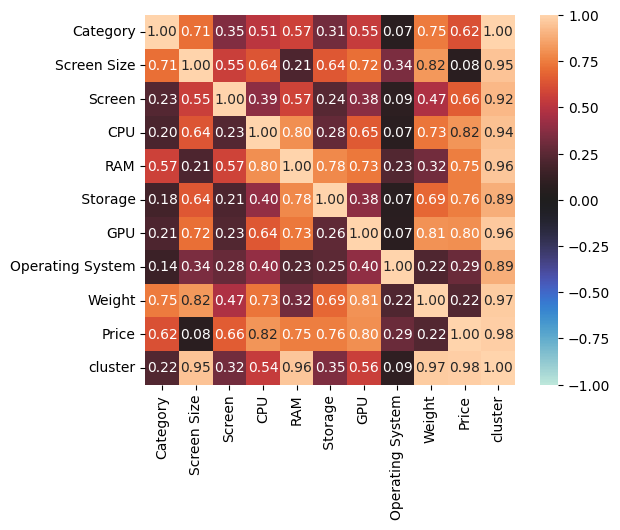

{'eps': 0.07, 'min_samples': 1} 0.3355949844319541 0.791256287116364
{1: 451, 2: 69, 3: 17, 4: 15, 5: 5, 6: 5, 7: 1, 8: 1, 9: 1, 11: 1, 12: 1, 25: 1, 35: 1, 39: 1, 76: 1}


,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Weight,Price,cluster
Manufacturer,,,,,,,,,,,
HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,3.000000,256GB SSD,Intel HD Graphics 620,Windows,1.86,6135480.00,0
HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,3.000000,256GB SSD,Intel HD Graphics 620,Windows,1.96,5326219.08,0
Dell,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,3.000000,256GB SSD,Intel HD Graphics 620,Windows,1.60,7638228.00,0
Lenovo,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,2.584963,256GB SSD,Intel HD Graphics 620,Windows,2.20,5148468.00,0
HP,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,3.000000,256GB SSD,Intel HD Graphics 620,Windows,1.95,8714160.00,0
...,...,...,...,...,...,...,...,...,...,...,...
Dell,2 in 1 Convertible,15.6,Full HD / Touchscreen 1920x1080,Intel Core i5 8250U 1.6GHz,3.000000,256GB SSD,Intel UHD Graphics 620,Windows,2.67,7104708.00,76
Samsung,Ultrabook,15.0,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,4.000000,256GB SSD,Nvidia GeForce 940MX,Windows,1.23,16441308.00,85
HP,Workstation,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,3.000000,256GB SSD,Nvidia Quadro M1200,Windows,2.60,15456696.84,88


In [5]:
laptops = optimize_clusters(laptops)

laptops


pokemon dataset

In [6]:
pokemon = pd.read_csv("pokemon/pokemon_alopez247.csv").iloc[:, 2:]
for c in pokemon.columns[pokemon.dtypes != object]:
    pokemon.loc[pokemon[c].isna(), c] = np.nanmedian(pokemon[c])
for c in pokemon.columns[pokemon.dtypes == object]:
    pokemon.loc[pokemon[c].isna(), c] = "none"

[1. 1. 1. 1. 1. 1. 1. 1. 1.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

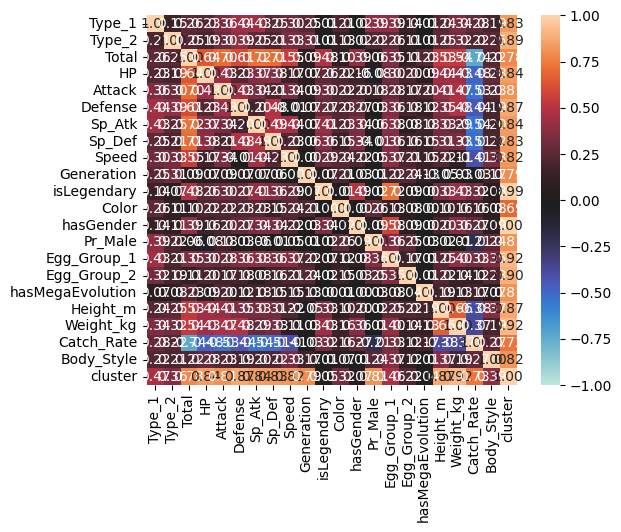

{'eps': 0.12, 'min_samples': 1} 0.37899893477322355 0.7284999753012841
{1: 220, 2: 64, 3: 22, 4: 8, 6: 1, 7: 2, 9: 2, 10: 1, 13: 1, 14: 1, 18: 1, 33: 1, 149: 1}


,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,...,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style,cluster
18,Normal,none,253,30,56,35,25,35,72,1,...,True,0.50,Field,none,False,0.30,3.5,255,quadruped,8
19,Normal,none,413,55,81,60,50,70,97,1,...,True,0.50,Field,none,False,0.71,18.5,127,quadruped,8
36,Fire,none,299,38,41,40,50,65,65,1,...,True,0.25,Field,none,False,0.61,9.9,190,quadruped,8
37,Fire,none,505,73,76,75,81,100,100,1,...,True,0.25,Field,none,False,1.09,19.9,75,quadruped,8
51,Normal,none,290,40,45,35,40,40,90,1,...,True,0.50,Field,none,False,0.41,4.2,255,quadruped,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Bug,Steel,500,70,130,100,55,80,65,2,...,True,0.50,Bug,none,True,1.80,118.0,25,four_wings,93
212,Bug,Rock,505,20,10,230,10,230,5,2,...,True,0.50,Bug,none,False,0.61,20.5,190,insectoid,94
213,Bug,Fighting,500,80,125,75,40,95,85,2,...,True,0.50,Bug,none,True,1.50,54.0,45,bipedal_tailless,95
217,Fire,none,250,40,40,40,70,40,20,2,...,True,0.50,Amorphous,none,False,0.71,35.0,190,serpentine_body,97


In [7]:
pokemon = optimize_clusters(pokemon, weight_num="uniform")

pokemon


  0%|          | 0/12 [00:00<?, ?it/s]

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [7.59494545 6.2799955  7.26759431 6.77767923 7.19824094 6.20825288
 7.23098544 3.32192809 3.5        5.08116007 6.22078031 5.80584351]


  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

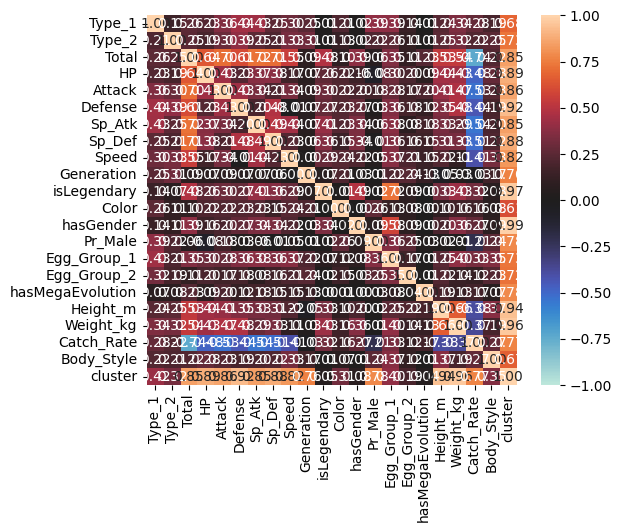

{'eps': 0.09, 'min_samples': 1} 0.23559405952762602 0.7197285858590976
{1: 314, 2: 38, 3: 11, 4: 2, 5: 2, 8: 1, 9: 1, 10: 1, 253: 1}


,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,...,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style,cluster
18,Normal,none,253,30,56,35,25,35,72,1,...,True,0.50,Field,none,False,0.30,3.5,255,quadruped,0
19,Normal,none,413,55,81,60,50,70,97,1,...,True,0.50,Field,none,False,0.71,18.5,127,quadruped,0
36,Fire,none,299,38,41,40,50,65,65,1,...,True,0.25,Field,none,False,0.61,9.9,190,quadruped,0
37,Fire,none,505,73,76,75,81,100,100,1,...,True,0.25,Field,none,False,1.09,19.9,75,quadruped,0
51,Normal,none,290,40,45,35,40,40,90,1,...,True,0.50,Field,none,False,0.41,4.2,255,quadruped,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,Dragon,none,452,68,75,53,83,113,60,6,...,True,0.50,Dragon,none,False,0.79,17.5,45,serpentine_body,91
705,Dragon,none,600,90,100,70,110,150,80,6,...,True,0.50,Dragon,none,False,2.01,150.5,45,bipedal_tailed,92
110,Ground,Rock,345,80,85,95,30,30,25,1,...,True,0.50,Monster,Field,False,0.99,115.0,120,quadruped,93
115,Water,none,295,30,40,70,70,25,60,1,...,True,0.50,Water_1,Dragon,False,0.41,8.0,225,head_base,95


In [8]:
pokemon = optimize_clusters(pokemon)

pokemon


cereal dataset

In [9]:
cereal = pd.read_csv("cereal.csv", index_col="name")

[1. 1.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

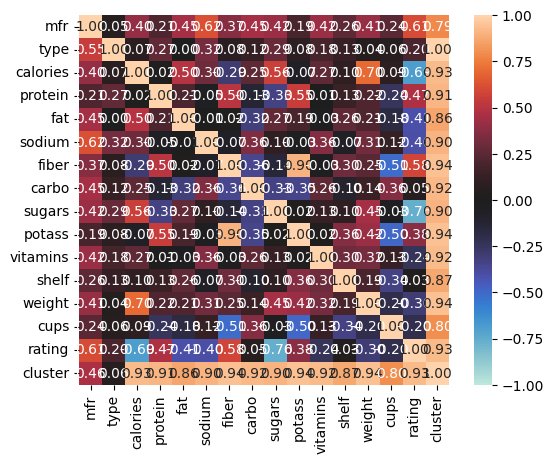

{'eps': 0.1, 'min_samples': 1} 0.4466566702839817 0.8700247643221581
{1: 13, 2: 9, 3: 2, 4: 2, 5: 1, 6: 1, 21: 1}


,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating,cluster
name,,,,,,,,,,,,,,,,
Apple Cinnamon Cheerios,G,C,110,2,2,180,1.5,10.5,10,70,25,1,1.0,0.75,29.509541,5
Apple Jacks,K,C,110,2,0,125,1.0,11.0,14,30,25,2,1.0,1.00,33.174094,5
Bran Chex,R,C,90,2,1,200,4.0,15.0,6,125,25,1,1.0,0.67,49.120253,5
Cinnamon Toast Crunch,G,C,120,1,3,210,0.0,13.0,9,45,25,2,1.0,0.75,19.823573,5
Cocoa Puffs,G,C,110,1,1,180,0.0,12.0,13,55,25,2,1.0,1.00,22.736446,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Special K,K,C,110,6,0,230,1.0,16.0,3,55,25,1,1.0,1.00,53.131324,26
Strawberry Fruit Wheats,N,C,90,2,0,15,3.0,15.0,5,90,25,2,1.0,1.00,59.363993,27
Total Raisin Bran,G,C,140,3,1,190,4.0,15.0,14,230,100,3,1.5,1.00,28.592785,28


In [10]:
cereal = optimize_clusters(cereal, weight_num="uniform")

cereal


  0%|          | 0/13 [00:00<?, ?it/s]

[1. 1. 1.] [4.27761344 3.32192809 2.92192809 5.45478355 4.07382548 4.98038854
 5.         5.73637857 1.81127812 2.         3.26485944 4.36406379
 5.90508194]


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

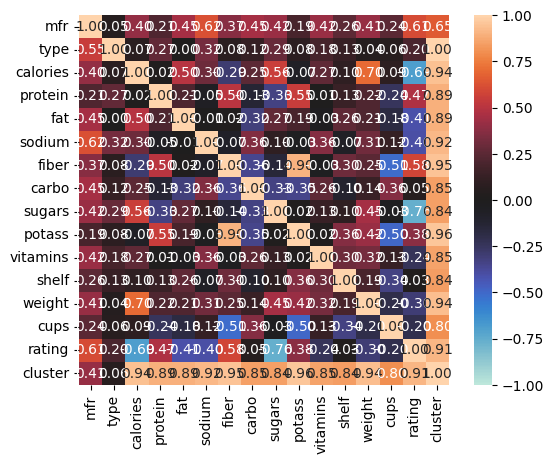

{'eps': 0.09, 'min_samples': 1} 0.3621946093902224 0.8527706011018732
{1: 21, 2: 6, 3: 1, 5: 1, 9: 1, 27: 1}


,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating,cluster
name,,,,,,,,,,,,,,,,
Apple Cinnamon Cheerios,G,C,110,2,2,180,1.5,10.5,10,70,25,1,1.0,0.75,29.509541,0
Apple Jacks,K,C,110,2,0,125,1.0,11.0,14,30,25,2,1.0,1.00,33.174094,0
Bran Chex,R,C,90,2,1,200,4.0,15.0,6,125,25,1,1.0,0.67,49.120253,0
Cinnamon Toast Crunch,G,C,120,1,3,210,0.0,13.0,9,45,25,2,1.0,0.75,19.823573,0
Cocoa Puffs,G,C,110,1,1,180,0.0,12.0,13,55,25,2,1.0,1.00,22.736446,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bran Flakes,P,C,90,3,0,210,5.0,13.0,5,190,25,3,1.0,0.67,53.313813,4
Great Grains Pecan,P,C,120,3,3,75,3.0,13.0,4,100,25,3,1.0,0.33,45.811716,6
Just Right Crunchy Nuggets,K,C,110,2,1,170,1.0,17.0,6,60,100,3,1.0,1.00,36.523683,7


In [11]:
cereal = optimize_clusters(cereal)

cereal


fast food dataset

In [12]:
fastfood = pd.read_csv("fastfood.csv", index_col="item")

fastfood.drop(["fiber", "protein", "vit_a", "vit_c", "calcium", "salad"], axis=1, inplace=True)

[1.] [1. 1. 1. 1. 1. 1. 1. 1. 1.]


  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

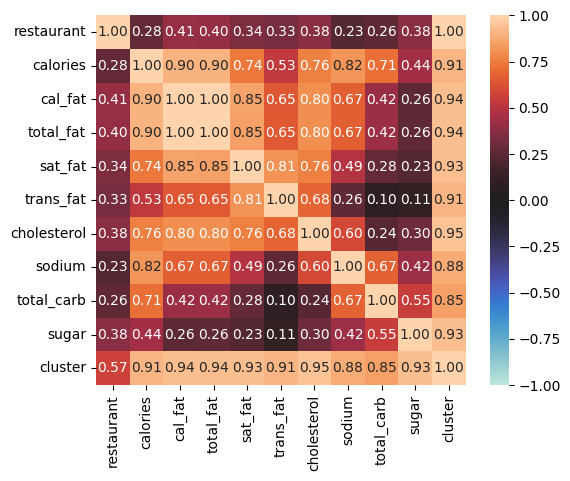

{'eps': 0.03, 'min_samples': 1} 0.45645033102556243 0.9105347169892228
{1: 76, 2: 9, 3: 9, 4: 2, 5: 2, 6: 2, 7: 2, 10: 2, 11: 1, 12: 1, 16: 1, 19: 1, 23: 1, 24: 1, 25: 1, 36: 1, 54: 1, 110: 1}


,restaurant,calories,cal_fat,total_fat,sat_fat,trans_fat,cholesterol,sodium,total_carb,sugar,cluster
item,,,,,,,,,,,
1/2 lb.* Cheesy Potato Burrito,Taco Bell,540,230,26,7.0,1.0,45,1360,59,4,111
1/2 lb.* Combo Burrito,Taco Bell,460,170,18,7.0,1.0,45,1320,53,3,111
7-Layer Burrito,Taco Bell,510,170,19,7.0,0.0,20,1090,68,4,111
Bean Burrito,Taco Bell,370,100,11,4.0,0.0,5,960,56,3,111
Beefy 5-Layer Burrito,Taco Bell,550,200,22,8.0,0.0,35,1270,68,5,111
...,...,...,...,...,...,...,...,...,...,...,...
Footlong Carved Turkey & Bacon w/ Cheese,Subway,1140,460,52,14.0,0.0,140,3200,92,16,94
Footlong Chicken & Bacon Ranch Melt,Subway,1140,500,56,20.0,2.0,190,2160,94,16,95
Footlong Corned Beef Reuben,Subway,940,260,30,9.0,0.0,170,3540,90,24,96


In [13]:
fastfood = optimize_clusters(fastfood, weight_num="uniform")

fastfood

  0%|          | 0/9 [00:00<?, ?it/s]

[1. 1.] [6.35601245 6.73099563 6.52728189 5.90242961 3.5        4.7142036
 6.65499    6.94828173 4.4126212 ]


  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

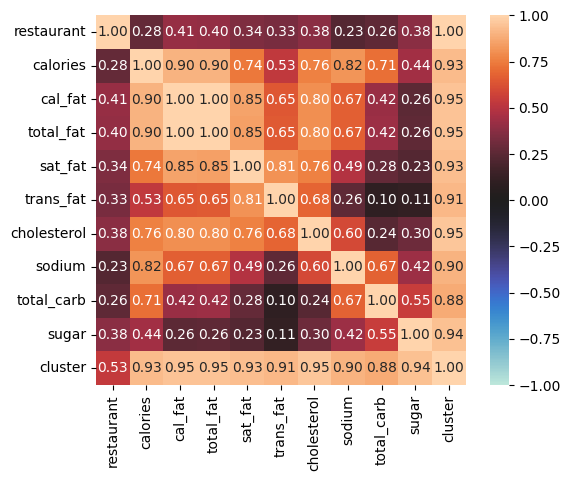

{'eps': 0.03, 'min_samples': 1} 0.4490416255584182 0.9189735715212927
{1: 95, 2: 14, 3: 11, 5: 1, 6: 2, 7: 2, 9: 1, 10: 4, 13: 1, 16: 1, 17: 1, 22: 1, 23: 1, 33: 1, 50: 1, 105: 1}


,restaurant,calories,cal_fat,total_fat,sat_fat,trans_fat,cholesterol,sodium,total_carb,sugar,cluster
item,,,,,,,,,,,
1/2 lb.* Cheesy Potato Burrito,Taco Bell,540,230,26,7.0,1.0,45,1360,59,4,0
1/2 lb.* Combo Burrito,Taco Bell,460,170,18,7.0,1.0,45,1320,53,3,0
7-Layer Burrito,Taco Bell,510,170,19,7.0,0.0,20,1090,68,4,0
Bean Burrito,Taco Bell,370,100,11,4.0,0.0,5,960,56,3,0
Beefy 5-Layer Burrito,Taco Bell,550,200,22,8.0,0.0,35,1270,68,5,0
...,...,...,...,...,...,...,...,...,...,...,...
Half Pound Beef 'n Cheddar Sandwich,Arbys,740,350,39,14.0,2.0,130,2530,48,9,95
Half Pound French Dip & Swiss,Arbys,750,330,36,17.0,2.0,150,3350,51,3,96
Pecan Chicken Salad Flatbread,Arbys,710,410,46,7.0,0.5,65,980,53,9,97


In [14]:
fastfood = optimize_clusters(fastfood)

fastfood

diabetes dataset

In [15]:
diabetes = pd.read_csv("diabetes.csv")

[] [1. 1. 1. 1. 1. 1. 1. 1. 1.]


  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

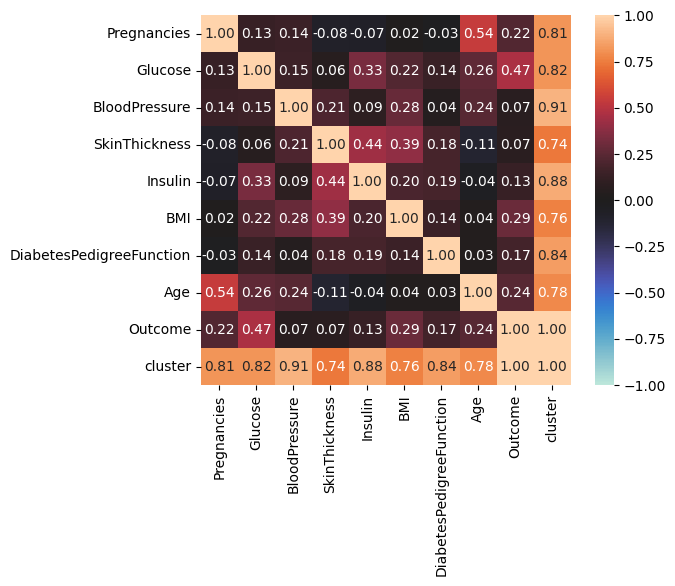

{'eps': 0.05, 'min_samples': 1} 0.24366585997271628 0.8537404838913247
{1: 201, 2: 15, 3: 11, 5: 1, 9: 1, 14: 1, 35: 1, 60: 1, 381: 1}


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,cluster
1,1,85,66,29,0,26.6,0.351,31,0,1
3,1,89,66,23,94,28.1,0.167,21,0,1
5,5,116,74,0,0,25.6,0.201,30,0,1
10,4,110,92,0,0,37.6,0.191,30,0,1
20,3,126,88,41,235,39.3,0.704,27,0,1
...,...,...,...,...,...,...,...,...,...,...
238,9,164,84,21,0,30.8,0.831,32,1,95
243,6,119,50,22,176,27.1,1.318,33,1,96
245,9,184,85,15,0,30.0,1.213,49,1,97
247,0,165,90,33,680,52.3,0.427,23,0,98


In [16]:
diabetes = optimize_clusters(diabetes, weight_num="uniform")

diabetes


  0%|          | 0/9 [00:00<?, ?it/s]

[1.] [4.96981578 7.0951959  5.91804164 5.36144074 7.03900104 6.73191255
 8.00498522 6.39806851 1.        ]


  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

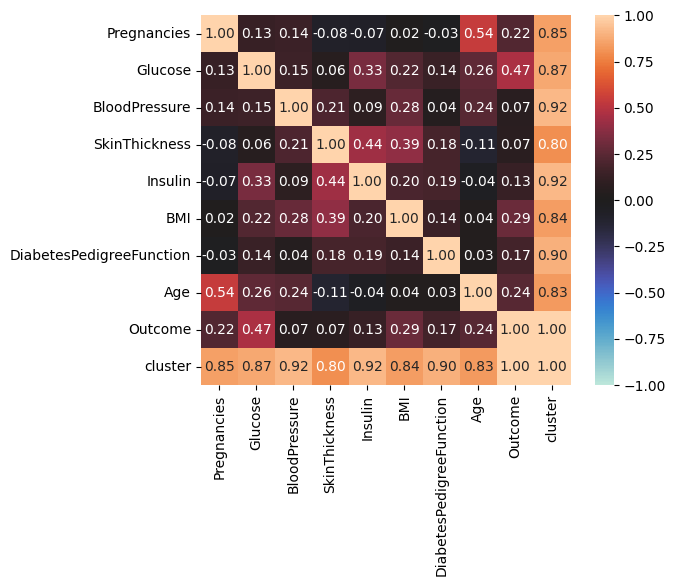

{'eps': 0.05, 'min_samples': 1} 0.24871498078946142 0.8918996214496213
{1: 251, 2: 21, 3: 11, 4: 2, 6: 1, 8: 1, 9: 1, 10: 1, 17: 1, 44: 1, 340: 1}


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,cluster
1,1,85,66,29,0,26.6,0.351,31,0,0
3,1,89,66,23,94,28.1,0.167,21,0,0
5,5,116,74,0,0,25.6,0.201,30,0,0
10,4,110,92,0,0,37.6,0.191,30,0,0
21,8,99,84,0,0,35.4,0.388,50,0,0
...,...,...,...,...,...,...,...,...,...,...
274,13,106,70,0,0,34.2,0.251,52,0,95
282,7,133,88,15,155,32.4,0.262,37,0,96
286,5,155,84,44,545,38.7,0.619,34,0,97
292,2,128,78,37,182,43.3,1.224,31,1,98


In [17]:
diabetes = optimize_clusters(diabetes)

diabetes


############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.8 as the correlation limit. Change this limit to fit your needs...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Binary_Classification problem ####
    Loaded train data. Shape = (768, 9)
#### Single_Label Binary_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
        No variabl

  0%|          | 0/35 [00:00<?, ?it/s]

[] [8.15637935 4.43134376 7.45971131 7.8362894  6.77165704 5.58864226
 8.59766478 6.43871845 6.86975245 7.87132419 7.54259005 7.44201159
 7.31104538 7.93845332 7.5090498  7.81266231 4.86047288 7.86041672
 6.47145425 7.4661309  8.17045435 6.7954517  6.01627899 8.42431843
 5.93246375 6.31069183 8.05764885 6.74984833 6.93045261 7.30964654
 6.80980911 7.84594845 6.97853315 6.36049991 1.        ]


  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

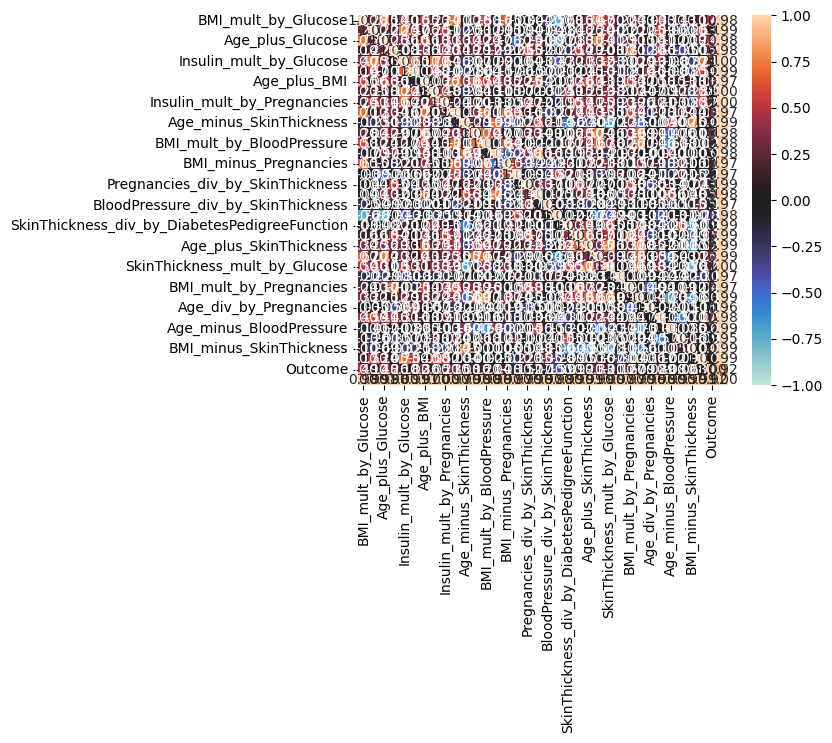

{'eps': 0.03, 'min_samples': 1} 0.21258902434176485 0.9805415012458768
{1: 505, 2: 35, 3: 6, 4: 3, 5: 2, 7: 2, 10: 1, 12: 1, 18: 1, 33: 1, 66: 1}


,BMI_mult_by_Glucose,Insulin_mult_by_DiabetesPedigreeFunction,Age_plus_Glucose,Pregnancies_mult_by_DiabetesPedigreeFunction,Insulin_mult_by_Glucose,Insulin_div_by_Pregnancies,Age_plus_BMI,Insulin_div_by_DiabetesPedigreeFunction,Insulin_mult_by_Pregnancies,BMI_plus_Pregnancies,...,BMI_mult_by_Pregnancies,BloodPressure_plus_SkinThickness,Age_div_by_Pregnancies,Glucose_mult_by_DiabetesPedigreeFunction,Age_minus_BloodPressure,BMI_div_by_DiabetesPedigreeFunction,BMI_minus_SkinThickness,Insulin_div_by_SkinThickness,Outcome,cluster
5,2969.6,0.000,146,1.005,0,0.000000,55.6,0.000000,0,30.6,...,128.0,74,6.000000,23.316,-44,127.363184,25.6,3.400000,0,2
10,4136.0,0.000,140,0.764,0,0.000000,67.6,0.000000,0,41.6,...,150.4,92,7.500000,21.010,-62,196.858639,37.6,3.400000,0,2
29,3989.7,0.000,155,1.685,0,0.000000,72.1,0.000000,0,39.1,...,170.5,92,7.600000,39.429,-54,101.186944,34.1,3.400000,0,2
90,1528.0,0.000,101,0.258,0,0.000000,40.1,0.000000,0,20.1,...,19.1,55,21.000000,20.640,-34,74.031008,19.1,3.400000,0,2
138,4024.8,0.000,158,0.000,0,6.666667,60.2,0.000000,0,31.2,...,0.0,80,8.500000,90.687,-51,44.381223,31.2,3.400000,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,2460.5,49.129,131,0.673,6935,73.000000,61.9,108.469539,73,26.9,...,25.9,95,36.000000,63.935,-38,38.484398,4.9,3.476190,0,95
344,3496.0,0.000,152,3.880,0,0.000000,93.8,0.000000,0,44.8,...,294.4,72,7.125000,46.075,-15,75.876289,36.8,3.400000,0,96
346,3989.3,54.282,161,0.654,11537,83.000000,50.7,126.911315,83,29.7,...,28.7,65,22.000000,90.906,-24,43.883792,9.7,4.368421,0,97
350,3882.4,0.000,121,0.948,0,0.000000,71.2,0.000000,0,46.2,...,168.8,80,7.250000,21.804,-51,178.059072,42.2,3.400000,0,98


In [18]:
diabetes_fw = fw.featurewiz(dataname=diabetes.drop("cluster", axis=1),
                            target="Outcome", feature_engg="interactions")[1]
diabetes2 = optimize_clusters(diabetes_fw.fillna(dict(zip(diabetes_fw.columns.tolist(),
                                                          np.nanmedian(diabetes_fw, axis=0).tolist()))))

diabetes2


airbnb dataset

[1. 1. 1. 1. 1. 1.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

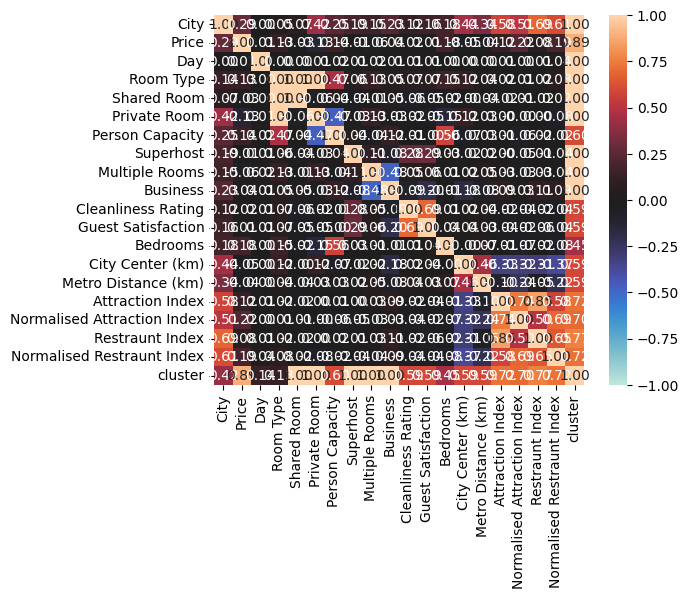

{'eps': 0.05, 'min_samples': 1} 0.6045154874702218 0.75256431633418
{1: 125, 2: 25, 3: 13, 4: 11, 5: 9, 6: 3, 7: 11, 8: 5, 9: 8, 10: 8, 11: 2, 12: 7, 13: 2, 14: 4, 15: 2, 16: 4, 17: 1, 18: 2, 19: 2, 20: 5, 21: 3, 22: 2, 23: 3, 24: 4, 25: 1, 26: 3, 27: 5, 28: 2, 29: 3, 30: 2, 31: 3, 33: 2, 34: 4, 35: 4, 36: 2, 37: 1, 38: 1, 41: 1, 42: 1, 43: 2, 44: 1, 45: 2, 47: 2, 48: 3, 49: 3, 51: 1, 52: 1, 53: 1, 55: 1, 58: 1, 59: 1, 61: 1, 62: 1, 63: 2, 64: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 78: 1, 79: 2, 81: 1, 89: 1, 98: 1, 131: 1, 181: 1}


,City,Price,Day,Room Type,Shared Room,Private Room,Person Capacity,Superhost,Multiple Rooms,Business,Cleanliness Rating,Guest Satisfaction,Bedrooms,City Center (km),Metro Distance (km),Attraction Index,Normalised Attraction Index,Restraunt Index,Normalised Restraunt Index,cluster
28390,Paris,370.957219,Weekend,Entire home/apt,False,False,4.0,False,0,0,9.0,93.0,2,3.537153,0.268537,271.332383,13.193557,597.414769,27.560136,47
27011,Paris,210.411036,Weekend,Entire home/apt,False,False,2.0,False,0,0,10.0,100.0,1,2.849778,0.243919,248.719746,12.094016,620.003563,28.602210,47
28492,Paris,219.032529,Weekend,Entire home/apt,False,False,2.0,False,0,0,9.0,94.0,1,4.252134,0.291596,282.667751,13.744740,619.618826,28.584461,47
27076,Paris,254.683568,Weekend,Entire home/apt,False,False,3.0,False,0,0,10.0,93.0,1,3.153473,0.157751,268.876594,13.074144,646.481365,29.823693,47
26834,Paris,188.507783,Weekend,Entire home/apt,False,False,3.0,False,0,0,6.0,60.0,0,5.686199,0.388262,273.300743,13.289268,579.146779,26.717391,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15496,Budapest,190.581379,Weekend,Entire home/apt,False,False,4.0,False,0,0,6.0,80.0,2,10.295960,7.922334,31.219722,1.863316,46.539126,4.068355,67
24763,Paris,359.073539,Weekday,Private room,False,True,5.0,False,0,0,8.0,85.0,2,3.081991,0.185783,322.389212,15.693798,689.179381,40.495861,70
9141,Barcelona,624.898178,Weekend,Entire home/apt,False,False,6.0,False,1,0,9.0,92.0,2,1.936465,0.470776,609.708545,23.541552,657.490906,14.442866,89
16795,Lisbon,228.893058,Weekday,Private room,False,True,6.0,True,0,1,10.0,98.0,3,0.713659,0.466954,399.388681,13.185533,964.344527,43.129086,91


In [19]:
airbnb = pd.read_csv('Aemf1.csv').sample(n=5000, random_state=0)

airbnb = optimize_clusters(airbnb, weight_num="uniform")

airbnb


  0%|          | 0/13 [00:00<?, ?it/s]

[1. 1. 1. 1. 1. 1. 1.] [ 3.57271961  3.          1.          1.          3.75        5.86749423
  3.64160417  8.96727734  6.97889585  6.33630352  8.47491564  9.53221882
 11.3773855 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

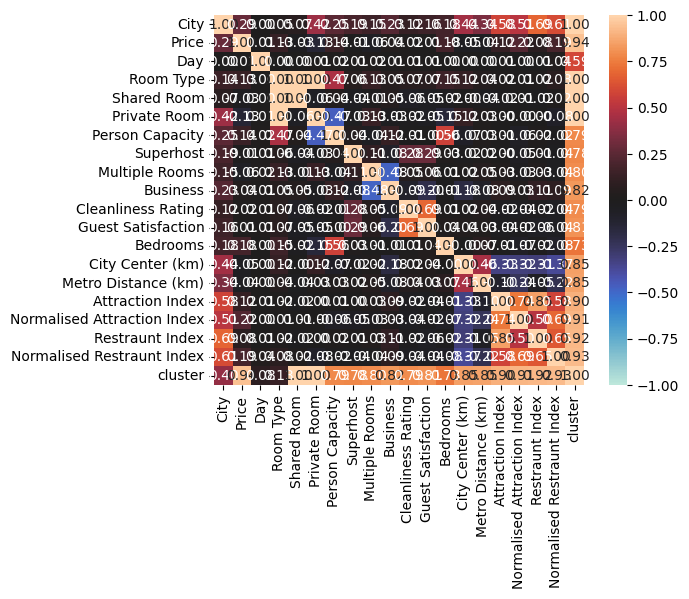

{'eps': 0.03, 'min_samples': 1} 0.4470198590062332 0.8209245971360094
{1: 906, 2: 150, 3: 56, 4: 31, 5: 24, 6: 10, 7: 7, 8: 5, 9: 3, 10: 1, 11: 1, 12: 2, 13: 3, 14: 2, 15: 2, 16: 1, 17: 2, 18: 2, 19: 1, 20: 3, 22: 2, 23: 2, 25: 1, 27: 1, 28: 1, 31: 1, 47: 2, 53: 1, 58: 1, 76: 1, 90: 1, 117: 1, 128: 1, 140: 1, 144: 1, 145: 1, 219: 1, 224: 1, 258: 1, 282: 1, 293: 1, 377: 1}


,City,Price,Day,Room Type,Shared Room,Private Room,Person Capacity,Superhost,Multiple Rooms,Business,Cleanliness Rating,Guest Satisfaction,Bedrooms,City Center (km),Metro Distance (km),Attraction Index,Normalised Attraction Index,Restraunt Index,Normalised Restraunt Index,cluster
36973,Rome,231.220630,Weekend,Entire home/apt,False,False,5.0,False,0,0,10.0,100.0,1,2.535965,0.448228,560.912186,12.427258,1372.777267,29.909486,62
34843,Rome,92.114184,Weekend,Entire home/apt,False,False,2.0,False,0,0,9.0,90.0,1,5.833543,2.034276,189.167662,4.191093,524.720503,11.432387,62
34158,Rome,155.471910,Weekend,Entire home/apt,False,False,4.0,False,0,0,10.0,92.0,2,4.162873,0.423529,659.187840,14.604599,1193.915631,26.012525,62
33829,Rome,288.265962,Weekend,Entire home/apt,False,False,2.0,False,0,0,9.0,90.0,1,3.092253,0.353893,352.760921,7.815575,859.495493,18.726322,62
34823,Rome,161.550511,Weekend,Entire home/apt,False,False,4.0,False,0,0,10.0,95.0,2,5.550061,0.864905,138.022051,3.057940,381.703199,8.316387,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37715,Rome,156.640872,Weekend,Entire home/apt,False,False,3.0,False,0,1,9.0,87.0,0,2.969319,1.787690,579.572506,12.840686,2950.064342,64.274745,99
11826,Berlin,455.735253,Weekend,Private room,False,True,4.0,False,0,1,10.0,90.0,1,4.993822,0.386336,134.096895,20.439129,170.580039,36.089551,991
11024,Berlin,191.408806,Weekday,Entire home/apt,False,False,3.0,False,0,1,10.0,97.0,1,5.679962,0.188649,70.702169,10.779945,86.263042,17.786849,994
11121,Berlin,519.304478,Weekday,Entire home/apt,False,False,2.0,False,0,1,10.0,80.0,1,2.035757,0.436028,230.820196,35.193108,262.426443,54.110536,996


In [20]:
airbnb = optimize_clusters(airbnb)

airbnb


customer shopping dataset

In [21]:
istanbul = pd.read_csv("customer_shopping_data.csv").sample(n=10000, random_state=0).iloc[:, 2:]
istanbul["price_per_unit"] = istanbul["price"] / istanbul["quantity"]
istanbul.drop("invoice_date", axis=1, inplace=True)

[1. 1. 1. 1.] [1. 1. 1. 1.]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

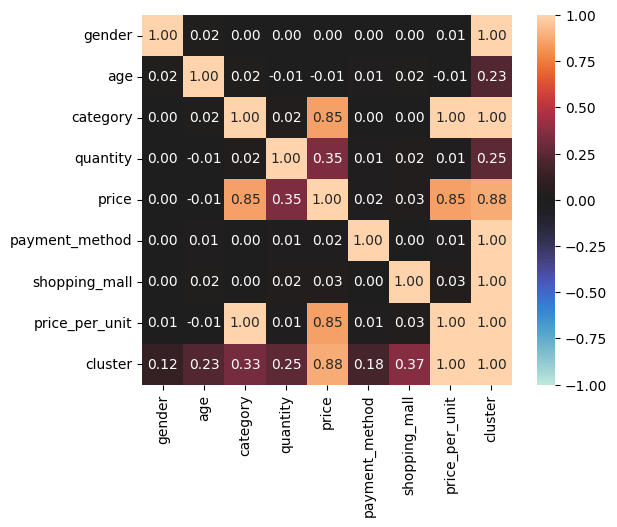

{'eps': 0.12, 'min_samples': 1} 0.6483486368598725 0.6504490626803627
{1: 47, 2: 28, 3: 24, 4: 19, 5: 23, 6: 20, 7: 18, 8: 27, 9: 19, 10: 16, 11: 15, 12: 10, 13: 17, 14: 10, 15: 20, 16: 11, 17: 14, 18: 9, 19: 10, 20: 6, 21: 8, 22: 9, 23: 4, 24: 12, 25: 7, 26: 5, 27: 3, 28: 2, 29: 2, 30: 6, 31: 6, 32: 4, 33: 5, 34: 3, 35: 2, 36: 4, 37: 2, 38: 2, 39: 2, 40: 3, 41: 3, 42: 5, 45: 1, 46: 4, 47: 4, 48: 2, 49: 2, 50: 1, 51: 1, 52: 1, 53: 1, 55: 1, 57: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 3, 64: 1, 65: 1, 67: 2, 69: 1, 70: 1, 71: 1, 72: 1, 75: 2, 83: 1, 84: 1, 87: 1, 90: 2, 91: 2, 92: 2, 94: 1, 100: 1, 103: 1, 134: 1, 137: 1, 138: 1, 154: 1, 189: 1, 203: 1}


,gender,age,category,quantity,price,payment_method,shopping_mall,price_per_unit,cluster
65992,Female,53,Clothing,3,900.24,Cash,Kanyon,300.08,38
1514,Female,34,Clothing,1,300.08,Cash,Kanyon,300.08,38
87290,Female,63,Clothing,1,300.08,Cash,Kanyon,300.08,38
23436,Female,33,Clothing,4,1200.32,Cash,Kanyon,300.08,38
46834,Female,22,Clothing,3,900.24,Cash,Kanyon,300.08,38
...,...,...,...,...,...,...,...,...,...
7314,Male,24,Shoes,4,2400.68,Debit Card,Emaar Square Mall,600.17,511
75393,Female,38,Technology,3,3150.00,Debit Card,Zorlu Center,1050.00,512
12166,Female,63,Technology,1,1050.00,Debit Card,Forum Istanbul,1050.00,513
31139,Male,34,Souvenir,5,58.65,Credit Card,Emaar Square Mall,11.73,514


In [22]:
istanbul = optimize_clusters(istanbul, weight_num="uniform")

istanbul


  0%|          | 0/4 [00:00<?, ?it/s]

[1. 1. 1. 1. 1.] [6.67242534 3.         4.57953163 2.75988587]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

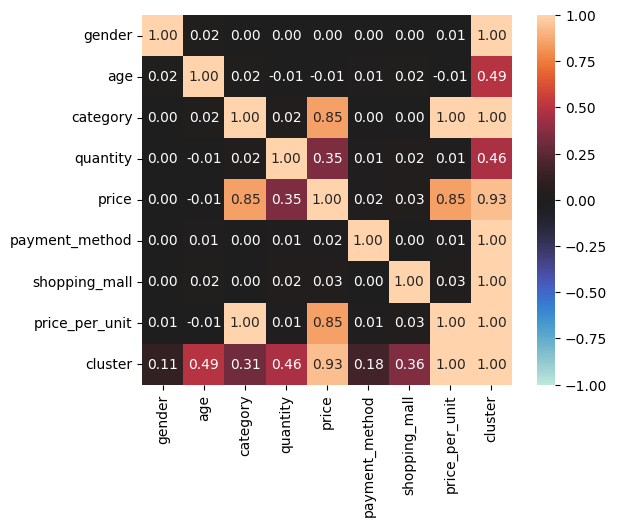

{'eps': 0.09, 'min_samples': 1} 0.6195744532943259 0.7077034942488301
{1: 497, 2: 172, 3: 98, 4: 57, 5: 25, 6: 32, 7: 38, 8: 15, 9: 11, 10: 13, 11: 9, 12: 9, 13: 8, 14: 8, 15: 11, 16: 6, 17: 9, 18: 10, 19: 8, 20: 3, 21: 5, 22: 8, 23: 4, 24: 4, 25: 3, 26: 4, 27: 2, 28: 3, 29: 4, 30: 1, 31: 5, 32: 4, 33: 6, 34: 3, 35: 1, 36: 4, 37: 2, 38: 2, 39: 4, 40: 2, 41: 2, 42: 6, 46: 4, 47: 4, 48: 2, 49: 2, 50: 1, 51: 1, 52: 1, 53: 1, 55: 1, 57: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 3, 64: 1, 65: 1, 67: 2, 69: 1, 70: 1, 71: 1, 72: 1, 75: 2, 83: 1, 84: 1, 87: 1, 90: 2, 91: 2, 92: 2, 94: 1, 100: 1, 103: 1, 134: 1, 137: 1, 138: 1, 154: 1, 189: 1, 203: 1}


,gender,age,category,quantity,price,payment_method,shopping_mall,price_per_unit,cluster
65992,Female,53,Clothing,3,900.24,Cash,Kanyon,300.08,0
1514,Female,34,Clothing,1,300.08,Cash,Kanyon,300.08,0
87290,Female,63,Clothing,1,300.08,Cash,Kanyon,300.08,0
23436,Female,33,Clothing,4,1200.32,Cash,Kanyon,300.08,0
46834,Female,22,Clothing,3,900.24,Cash,Kanyon,300.08,0
...,...,...,...,...,...,...,...,...,...
61774,Male,20,Souvenir,5,58.65,Debit Card,Metropol AVM,11.73,992
60884,Male,57,Souvenir,3,35.19,Credit Card,Cevahir AVM,11.73,995
32883,Male,23,Souvenir,5,58.65,Credit Card,Cevahir AVM,11.73,996
38388,Female,33,Books,4,60.60,Credit Card,Emaar Square Mall,15.15,997


In [23]:
istanbul = optimize_clusters(istanbul)

istanbul
